<a href="https://colab.research.google.com/github/naye971012/2023_sanhak_ML_study/blob/main/2023%EC%82%B0%ED%95%99_5%EC%9B%94_3%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html

11.1 ~ 11.6 단원 내용 (attention)

#import module

In [1]:
!pip install d2l==1.0.0-alpha1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00


In [ ]:
import torch
from d2l import torch as d2l

#11-1

In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

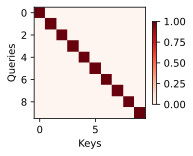

In [ ]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

#11-2

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

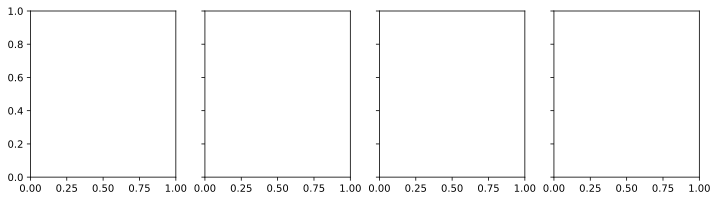

In [ ]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

In [ ]:
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

In [ ]:
def f(x):
    return 2 * torch.sin(x) + x**2

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [ ]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

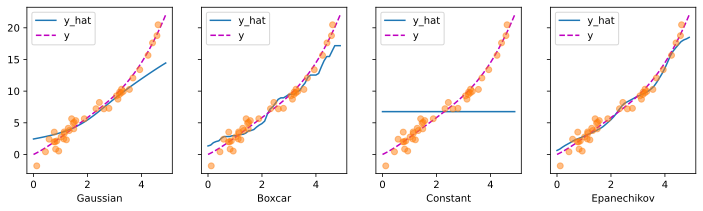

In [ ]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

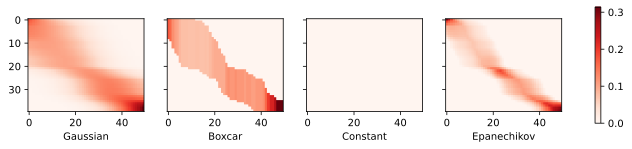

In [ ]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

#11-3

In [ ]:
def masked_softmax(X, valid_lens):  
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [ ]:
masked_softmax(torch.rand(2, 2, 6), torch.tensor([2, 5]))

tensor([[[0.6501, 0.3499, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3561, 0.6439, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.1765, 0.2304, 0.2223, 0.2351, 0.1357, 0.0000],
         [0.1521, 0.2476, 0.2288, 0.1230, 0.2484, 0.0000]]])

In [ ]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

In [ ]:
import math

In [ ]:
class DotProductAttention(nn.Module):  
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

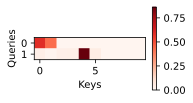

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [ ]:
class AdditiveAttention(nn.Module):  
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


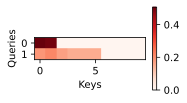

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

#11-4

In [14]:
class AttentionDecoder(d2l.Decoder):  
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [15]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [16]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

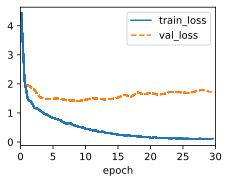

In [17]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

#11-5

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class MultiHeadAttention(d2l.Module): 
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [5]:
@d2l.add_to_class(MultiHeadAttention)  
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [6]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#11-6

In [7]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens),
                (batch_size, num_queries, num_hiddens))

In [9]:
class PositionalEncoding(nn.Module): 
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

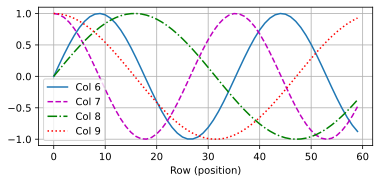

In [10]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [11]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


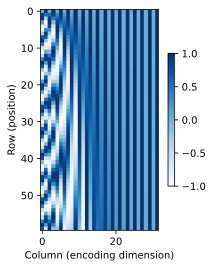

In [12]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')